# SDO HMII 이미지에서 흑점 탐지

* 이 노트북을 구글 코랩에서 실행하고자 한다면 [파일] - [드라이브에 사본 저장]을 하여 본인의 소유로 만든 후에 코드를 실행하거나 수정할 수 있습니다.

* 이 파일은 실제 수업에 사용하므로 필요에 따라 예고 없이 변경될 수 있습니다.

* If you have any questions or comments on this document, please email me(Kiehyun.Park@gmail.com).

* 이 파일(문서)는 공교육 현장에서 수업시간에 자유롭게 사용할 수 있으나, 다른 목적으로 사용할 시에는 사전에 연락을 주셔서 상의해 주시기 바랍니다.

이 자료는 SDO image에서 흑점을 찾는 내용입니다. https://github.com/seungwonpark/SunSpotTracker 를 참고하여 제작되었습니다.

## 필요한 환경



### 한글 폰트 설치 (matplotlib에서 한글 폰트 깨질 경우)

구글 코랩에서 현재의 Jupyter notebook을 실행한다면 matplotlib 그래프에 한글을 사용하기 위해서 폰트를 설치해야 합니다.

아래 코드의 주석을 제거한 후에 셀을 실해 주세요. 그리고 나서 런타임 다시 시작을 해 줘야 matplotlib 그래프에서 한글을 사용할 수 있습니다.

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

#### 런타임 다시 시작

위의 셀을 실행한 다음 반드시 다음 과정을 수행해야 합니다.

* [메뉴]-[런타임]-[런터임 다시 시작]

* [메뉴]-[런타임]-[이전 셀 실행]

#### 한글 폰트 사용

위에서 한글 폰트를 설치하고, 런타임 다시시작을 했다면 구글 코랩에서 폰트 경로를 설정하여 한글 사용이 가능해 집니다.

In [ ]:
#visualization
import matplotlib as mpl
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

# 브라우저에서 바로 그려지도록
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumBarunGothic')

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

plt.rcParams.update({'figure.max_open_warning': 0})

import warnings
warnings.filterwarnings('ignore')

### 모듈 설치 및 버전 확인

아래 셀을 실행하면 이 노트북을 실행하는데 필요한 모듈을 설치하고 파이썬 및 관련 모듈의 버전을 확인할 수 있습니다.

In [ ]:
# Install a pip package in the current Jupyter kernel
import importlib, sys, subprocess
print(f"sys.executable: {sys.executable}")

packages = "numpy, matplotlib, opencv-python, version_information" # required modules
pkgs = packages.split(", ")
for pkg in pkgs :
    if not importlib.util.find_spec(pkg):
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
        print(f"**** {pkg} module is now being installed.")
    else:
        print(f"oooo {pkg} module is already installed.")
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information {packages}
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

sys.executable: /usr/bin/python3
oooo numpy module is already installed.
oooo matplotlib module is already installed.
**** opencv-python module is now being installed.
oooo version_information module is already installed.
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information
This notebook was generated at 2024-12-09 06:49:10 (UTC = GMT+0000) 
0 Python     3.10.12 64bit [GCC 11.4.0]
1 IPython    7.34.0
2 OS         Linux 6.1.85+ x86_64 with glibc2.35
3 numpy      1.26.4
4 matplotlib 3.8.0
5 opencv-python 4.10.0.84
6 version_information 1.0.4


## 태양관측 위성




### SOHO

소호 태양 관측 위성(Solar and Heliospheric Observatory, [SOHO](https://sohowww.nascom.nasa.gov/data/realtime/realtime-update.html))은 1995년 12월 태양을 연구하기 위해 쏘아올려진 인공위성이며, 1996년 5월 과학 임무를 시작했습니다. 이는 유럽우주국과 미국항공우주국의 합작 프로젝트입니다. 2년 임무를 목표로 계획되었으며, 소호는 우주에서 10년이 지난 2005년에도 작동을 계속하고 있으며, 원래의 과학 임무에 더해, 현재는 우주기상예보를 위한 태양의 정보를 거의 실시간으로 제공해 주고 있습니다. [위키백과]


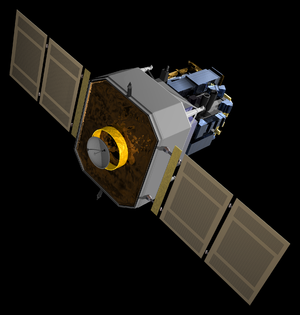

###SDO

태양 활동 관측 위성(Solar Dynamics Observatory, [SDO](https://sdo.gsfc.nasa.gov/) )은 2010년 2월 케이프커내버럴 공군 기지에서 발사된 태양 관측선입니다. 플래그쉽 프로그램과 LWS의 일환입니다. 태양의 자기장을 탐사하고 태양 활동, 태양의 모습 등을 아는 것이 목적입니다. [위키백과]





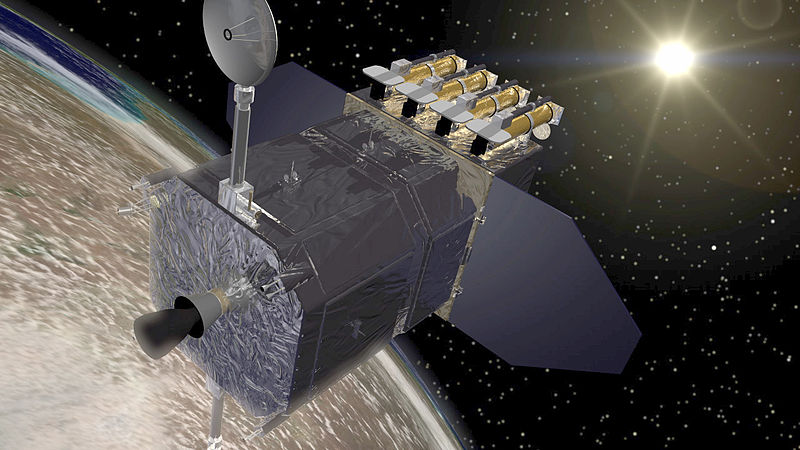

### The sun data

SDO 사이트에서는 자료를 검색하여 다운로드 받을 수 있는 툴(https://sdo.gsfc.nasa.gov/data/aiahmi/ )을 제공하고 있습니다.

SDO 자료가 저장되어 있는 주소([https://sdo.gsfc.nasa.gov/assets/img/browse/](https://sdo.gsfc.nasa.gov/assets/img/browse/))에 접속하면 YYYY/MM/DD 형태의 폴더 안에 자료가 들어 있음을 알 수 있습니다.


## 데이터 저장

### 데이터 저장 폴더 생성

위성영상을 저장할 폴더를 "SDO_images" 라는 이름으로 생성해 보겠습니다.

* 만약 리눅스 시스템 이라면 shell 명령어로 가능한데, "!"를 붙이면 shell 명령어를 실행할 수 있습니다.
> !mkdir SDO_images

아래 코드를 실행하면 OS의 영향을 받지 않기 위하여 pathlib을 사용하여 폴더를 생성할 수 있습니다.

In [ ]:
import os
from pathlib import Path
BASEPATH = Path("./")
save_dir_name = "SDO_images"
print(f"BASEPATH: {BASEPATH}")

if not (BASEPATH/save_dir_name).exists():
    os.mkdir(str(BASEPATH/save_dir_name))
    print (f"{str(BASEPATH/save_dir_name)} is created...")
else :
    print (f"{str(BASEPATH/save_dir_name)} is already exist...")

BASEPATH: .
SDO_images is already exist...


shell 명령어로 폴더가 생성되었는지 확인해 봅니다.

폴더 생성을 확인하는 또 다른 방법은 이 창 오른쪽에서 [파일] 목록을 확인해 볼 수 있습니다.

In [ ]:
!ls -al

total 340
drwxr-xr-x 1 root root   4096 Dec  9 06:43 .
drwxr-xr-x 1 root root   4096 Dec  9 04:42 ..
-rw-r--r-- 1 root root 163496 Dec 13  2017 20150102_032325_1024_HMII.jpg
-rw-r--r-- 1 root root 163496 Dec 13  2017 20150102_032325_1024_HMII.jpg.1
drwxr-xr-x 4 root root   4096 Dec  5 14:23 .config
drwxr-xr-x 1 root root   4096 Dec  5 14:24 sample_data
drwxr-xr-x 2 root root   4096 Dec  9 04:46 SDO_images


### HMII 데이터 다운로드

SDO에서 제공하는 여러 자료들 중에서 1024 pixel의 HMII 자료를 이용하여 흑점을 찾아 보겠습니다.

파일을 다운받기 위하여 [20170228_231038_1024_MHII.jpg(click)](https://sdo.gsfc.nasa.gov/assets/img/browse/2017/02/28/20170228_231038_1024_HMII.jpg)을 새창에서 열어 주소창에 나타나는 url을 확인해 봅니다.

GNU Wget은 HTTP 통신 또는 FTP 통신을 사용해 서버에서 파일 또는 콘텐츠를 다운로드할 때 사용하는 소프트웨어 입니다. Wget의 특징은 여러 파일을 한 번에 다운로드하거나 웹 페이지의 링크를 순회하며 여러 콘텐츠를 자동으로 다운로드할 때 매우 편리합니다.

구글 코랩도 wget을을 지원해주니 아래 셀을 실행하면 자신의 [작업 영역]에 저장해 보겠습니다. 하지만 이 파일은 이 런타임이 재실행 될때는 삭제됨에 유의하시기 바랍니다.

In [ ]:
fname = "20170228_231038_1024_HMII.jpg"
fid = "1yxW326FtXQY_D9VL0DST_pv8QiZ2GBeW"

#wget을 이용 (SDO에서 직접 받을 경우)
#!wget https://sdo.gsfc.nasa.gov/assets/img/browse/2017/02/28/20170228_231038_1024_HMII.jpg -O {save_dir_name}/{fname}

# wget을 이용(나의 구굴드라이브에서 공유한 파일을 구글 코랩에서 사용할 경우)
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id={fid}" -O {save_dir_name}/{fname}

# gdown을 이용(나의 구굴드라이브에서 공유한 파일을 다운로드)
#!gdown {fid} -O {save_dir_name}/{fname}

--2024-12-09 06:49:11--  https://docs.google.com/uc?export=download&id=1yxW326FtXQY_D9VL0DST_pv8QiZ2GBeW
Resolving docs.google.com (docs.google.com)... 142.251.2.138, 142.251.2.102, 142.251.2.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1yxW326FtXQY_D9VL0DST_pv8QiZ2GBeW&export=download [following]
--2024-12-09 06:49:11--  https://drive.usercontent.google.com/download?id=1yxW326FtXQY_D9VL0DST_pv8QiZ2GBeW&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.137.132, 2607:f8b0:4023:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.137.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155011 (151K) [image/jpeg]
Saving to: ‘SDO_images/20170228_231038_1024_HMII.jpg’

SDO_images/20170228 100%[===================>] 151.38K  --.-KB

### 데이터 확인

* 코랩을 사용할 경우에는 오른쪽의 [파일]창에서 확인할 수 있습니다.
* linux shell 명령어로 다음과 같이 확인해 볼 수 있습니다.
> ls -l SDO_image

OS의 영향을 받지 않고 파이썬으로 확인하는 방법은 아래와 같이 하면 됩니다.

In [ ]:
from pathlib import Path

fpaths = sorted(list((BASEPATH/save_dir_name).glob('*')))
print(f"fpaths: {fpaths}")
print(f"len(fpaths): {len(fpaths)}")

fpaths: [PosixPath('SDO_images/20170228_231038_1024_HMII.jpg'), PosixPath('SDO_images/20170228_231038_1024_HMII.png')]
len(fpaths): 2


## Image handling

### Read image

openCVdml imread 함수로 이미지를 읽어 픽셀 값들을 확인해 볼 수 있습니다. numpy.ndarray의 형태로 읽어 들였음을 알 수 있습니다.

In [ ]:
import cv2

# read image as ndarray
print(f"str(fpaths): {str(fpaths)}")
print(f"str(fpaths[0]): {str(fpaths[0])}")
sun_im = cv2.imread(str(fpaths[0]), cv2.IMREAD_UNCHANGED)

# 형태를 보자.
print("type(sun_im): ", type(sun_im))

str(fpaths): [PosixPath('SDO_images/20170228_231038_1024_HMII.jpg'), PosixPath('SDO_images/20170228_231038_1024_HMII.png')]
str(fpaths[0]): SDO_images/20170228_231038_1024_HMII.jpg
type(sun_im):  <class 'numpy.ndarray'>


image dim을 확인해 보겠습니다.

In [ ]:
import numpy as np
print("np.shape(sun_im): ", np.shape(sun_im))
print("sun_im.ndim: ", sun_im.ndim)

np.shape(sun_im):  (1024, 1024)
sun_im.ndim:  2


### Display image

sun_im 에 픽셀 값들이 배열 (1024, 1024) 형태의 배열로 들어 있습니다. matplotlib의 imshow 함수를 이용하여 화면에 디스플레이 해 보겠습니다.

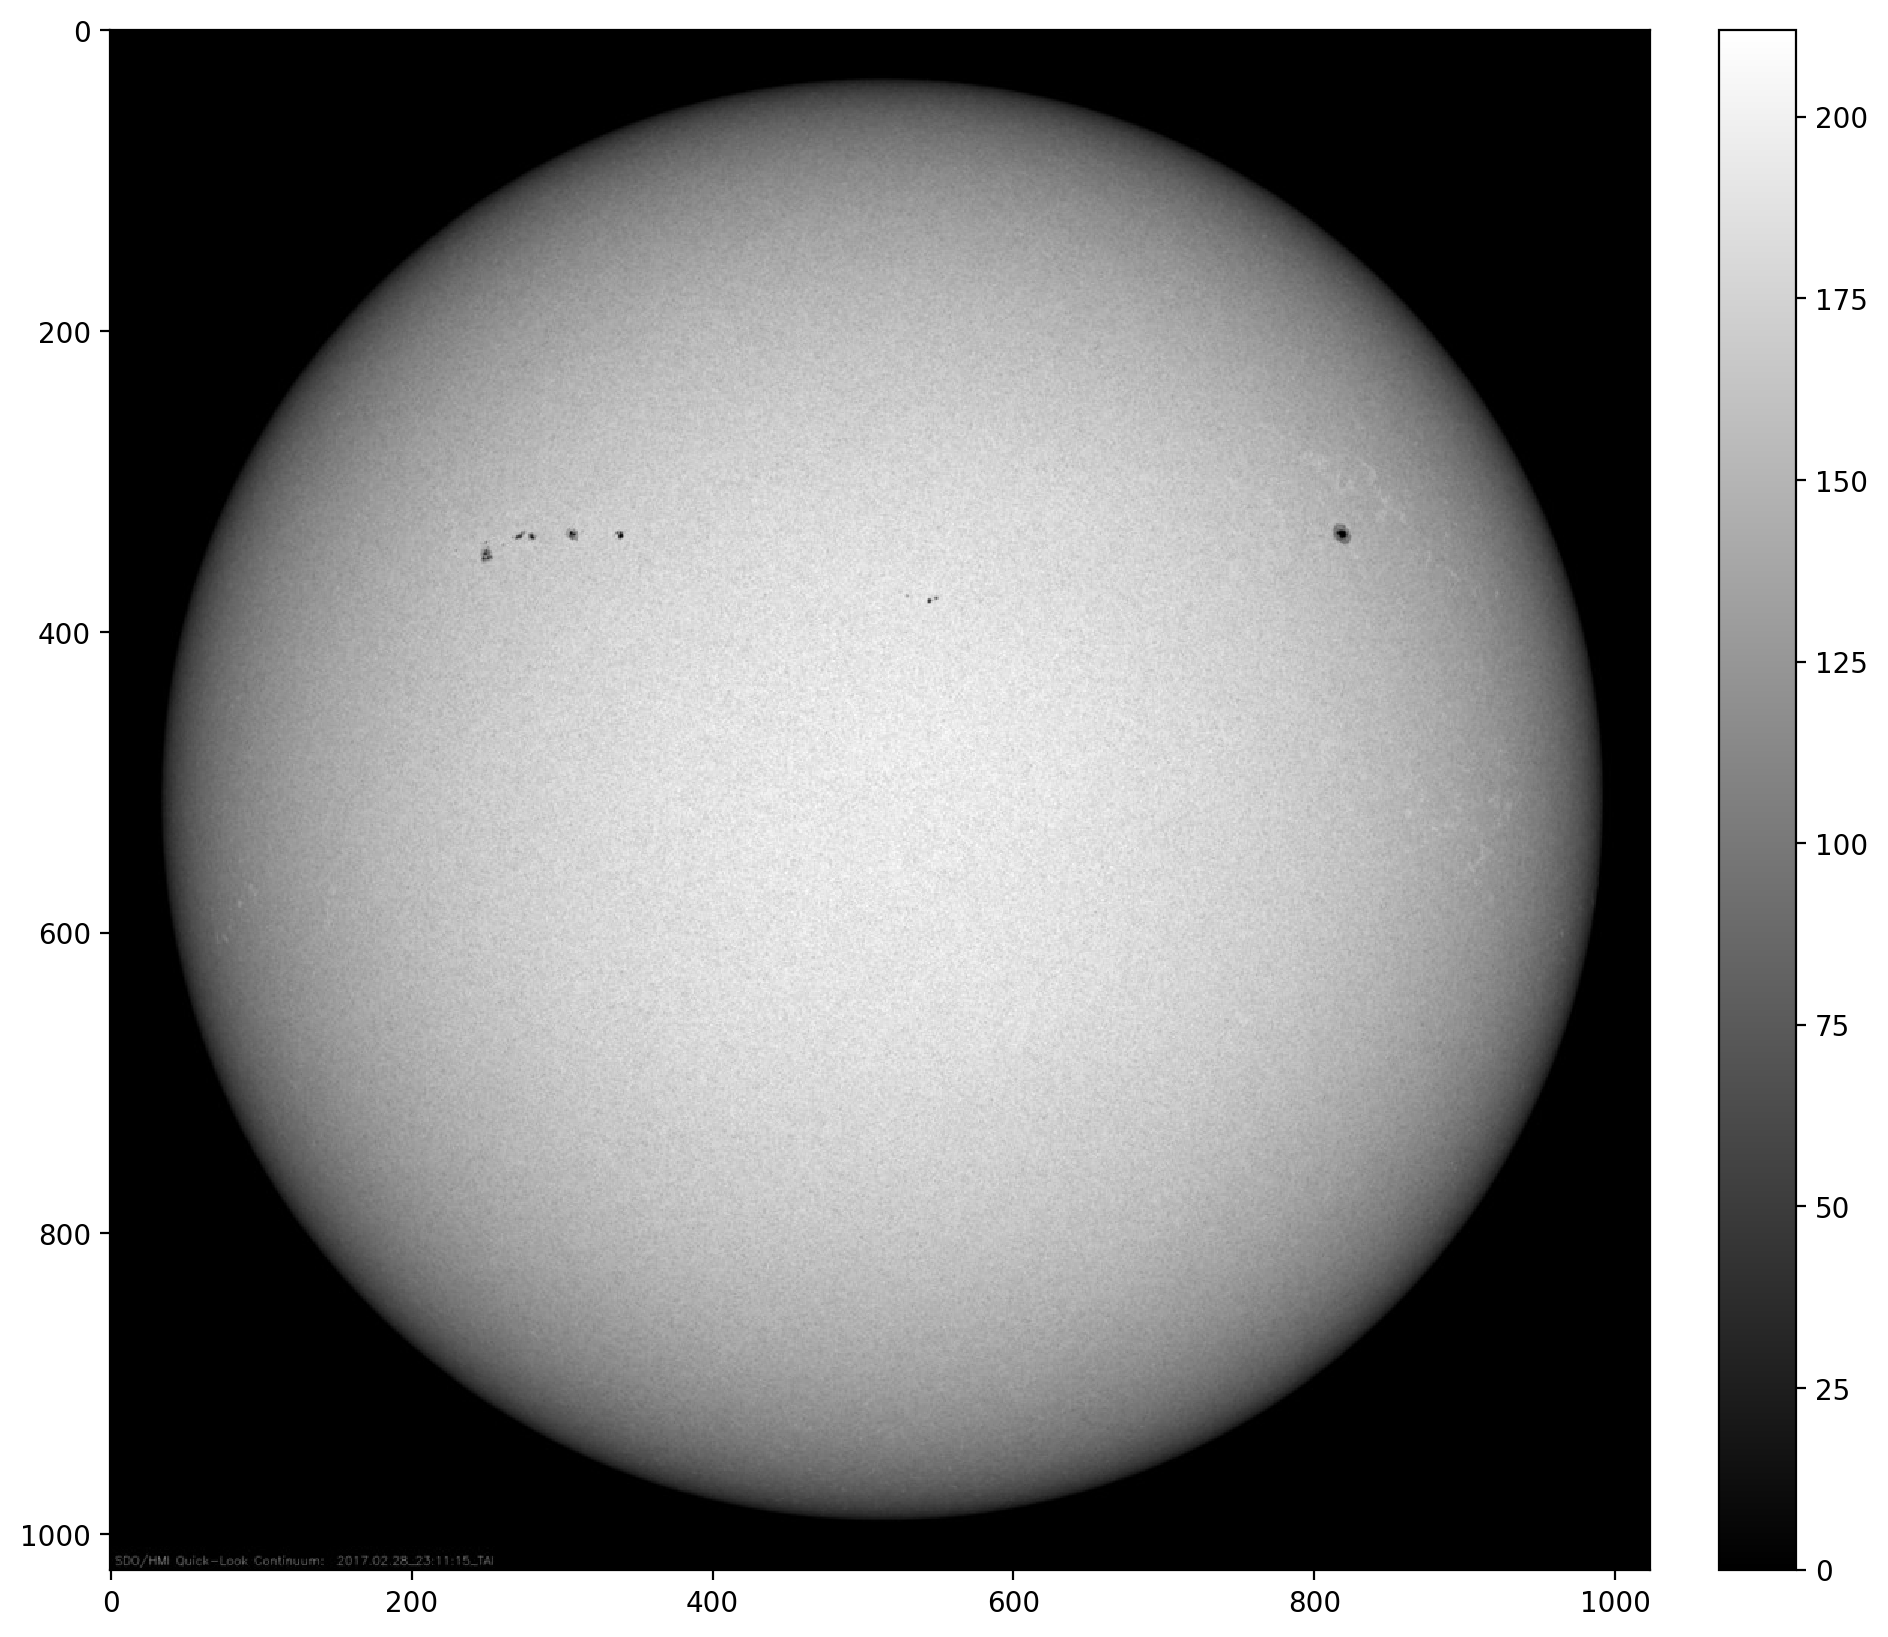

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# Set figure width to 10 and height to 10
plt.rcParams["figure.figsize"] = [11,10]

# display sun image
im = ax.imshow(sun_im,
           cmap = 'gray',
           #origin='upper',  # 이미지를 어느쪽 부터 나타낼 것인가?
           interpolation = 'None')

fig.colorbar(im, fraction=0.046, pad=0.04)
# to hide tick values on X and Y axis
#plt.xticks([]), plt.yticks([])

plt.show()

In [ ]:
im_width, im_height = np.shape(sun_im)
im_center_x, im_center_y = im_width/2, im_height/2
print('sun image dimension:', np.shape(sun_im))
print('sun image dimension: {}'.format(np.shape(sun_im)))

sun image dimension: (1024, 1024)
sun image dimension: (1024, 1024)


## image processing

[openCV](https://pypi.org/project/opencv-python/)는 강력한 이미지 프로세싱 모듈입니다. 그 기능을 일부 이용해 보겠습니다.


### 태양 이미지의 테두리 찾기

태양 테두리에 잘 맞는 원의 방정식을 찾아보겠습니다. [Hough Circle Transform
](https://opencv-python.readthedocs.io/en/latest/doc/26.imageHoughCircleTransform/imageHoughCircleTransform.html)을 이용하면 이미지에서 원을 찾아 그 정식을 알려줍니다.


In [ ]:
# detect circles of sun from the image
sun_circle = cv2.HoughCircles(sun_im, cv2.HOUGH_GRADIENT, 2, 200)

print("sun_circle: ", sun_circle)
print('type(sun_circle): ', type(sun_circle) )
print('sun_circle.shape: ', sun_circle.shape)

sun_circle:  [[[515.  511.  480.4]]]
type(sun_circle):  <class 'numpy.ndarray'>
sun_circle.shape:  (1, 1, 3)


자료 형태를 보면 numpy.ndarray이며, 3D 형태임을 알수 있습니다. 인덱싱하는 방법은 아래와 같습니다.

In [ ]:
print("sun_circle: ", sun_circle)
print("sun_circle[0]: ", sun_circle[0])
print("sun_circle[0][0]: ", sun_circle[0][0])
print(sun_circle[0,0,:])

sun_circle:  [[[515.  511.  480.4]]]
sun_circle[0]:  [[515.  511.  480.4]]
sun_circle[0][0]:  [515.  511.  480.4]
[515.  511.  480.4]


픽셀 주소를 정수로 반올림을 하는 편이 좋겠습니다.

In [ ]:
# convert the (x, y, r) coordinates and radius of the circles to integers
sun_circle = np.round(sun_circle[0,0,:]).astype(int)
print('circle of sun', sun_circle )

circle of sun [515 511 480]


[Hough Circle Transform
](https://opencv-python.readthedocs.io/en/latest/doc/26.imageHoughCircleTransform/imageHoughCircleTransform.html)을 이용하여 이미지에서 원을 찾는 과정은 경우에 따라 실패할 수도 있으며, 실패할 경우 이미지의 중심인 [512, 512, 480] 정도로 사용해도 됩니다.

### 원 그리기

태양 이미지 위에 원을 그려보겠습니다. [matplotlib.patches.Circle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Circle.html) 함수를 이용하면 원을 그릴 수 있습니다.


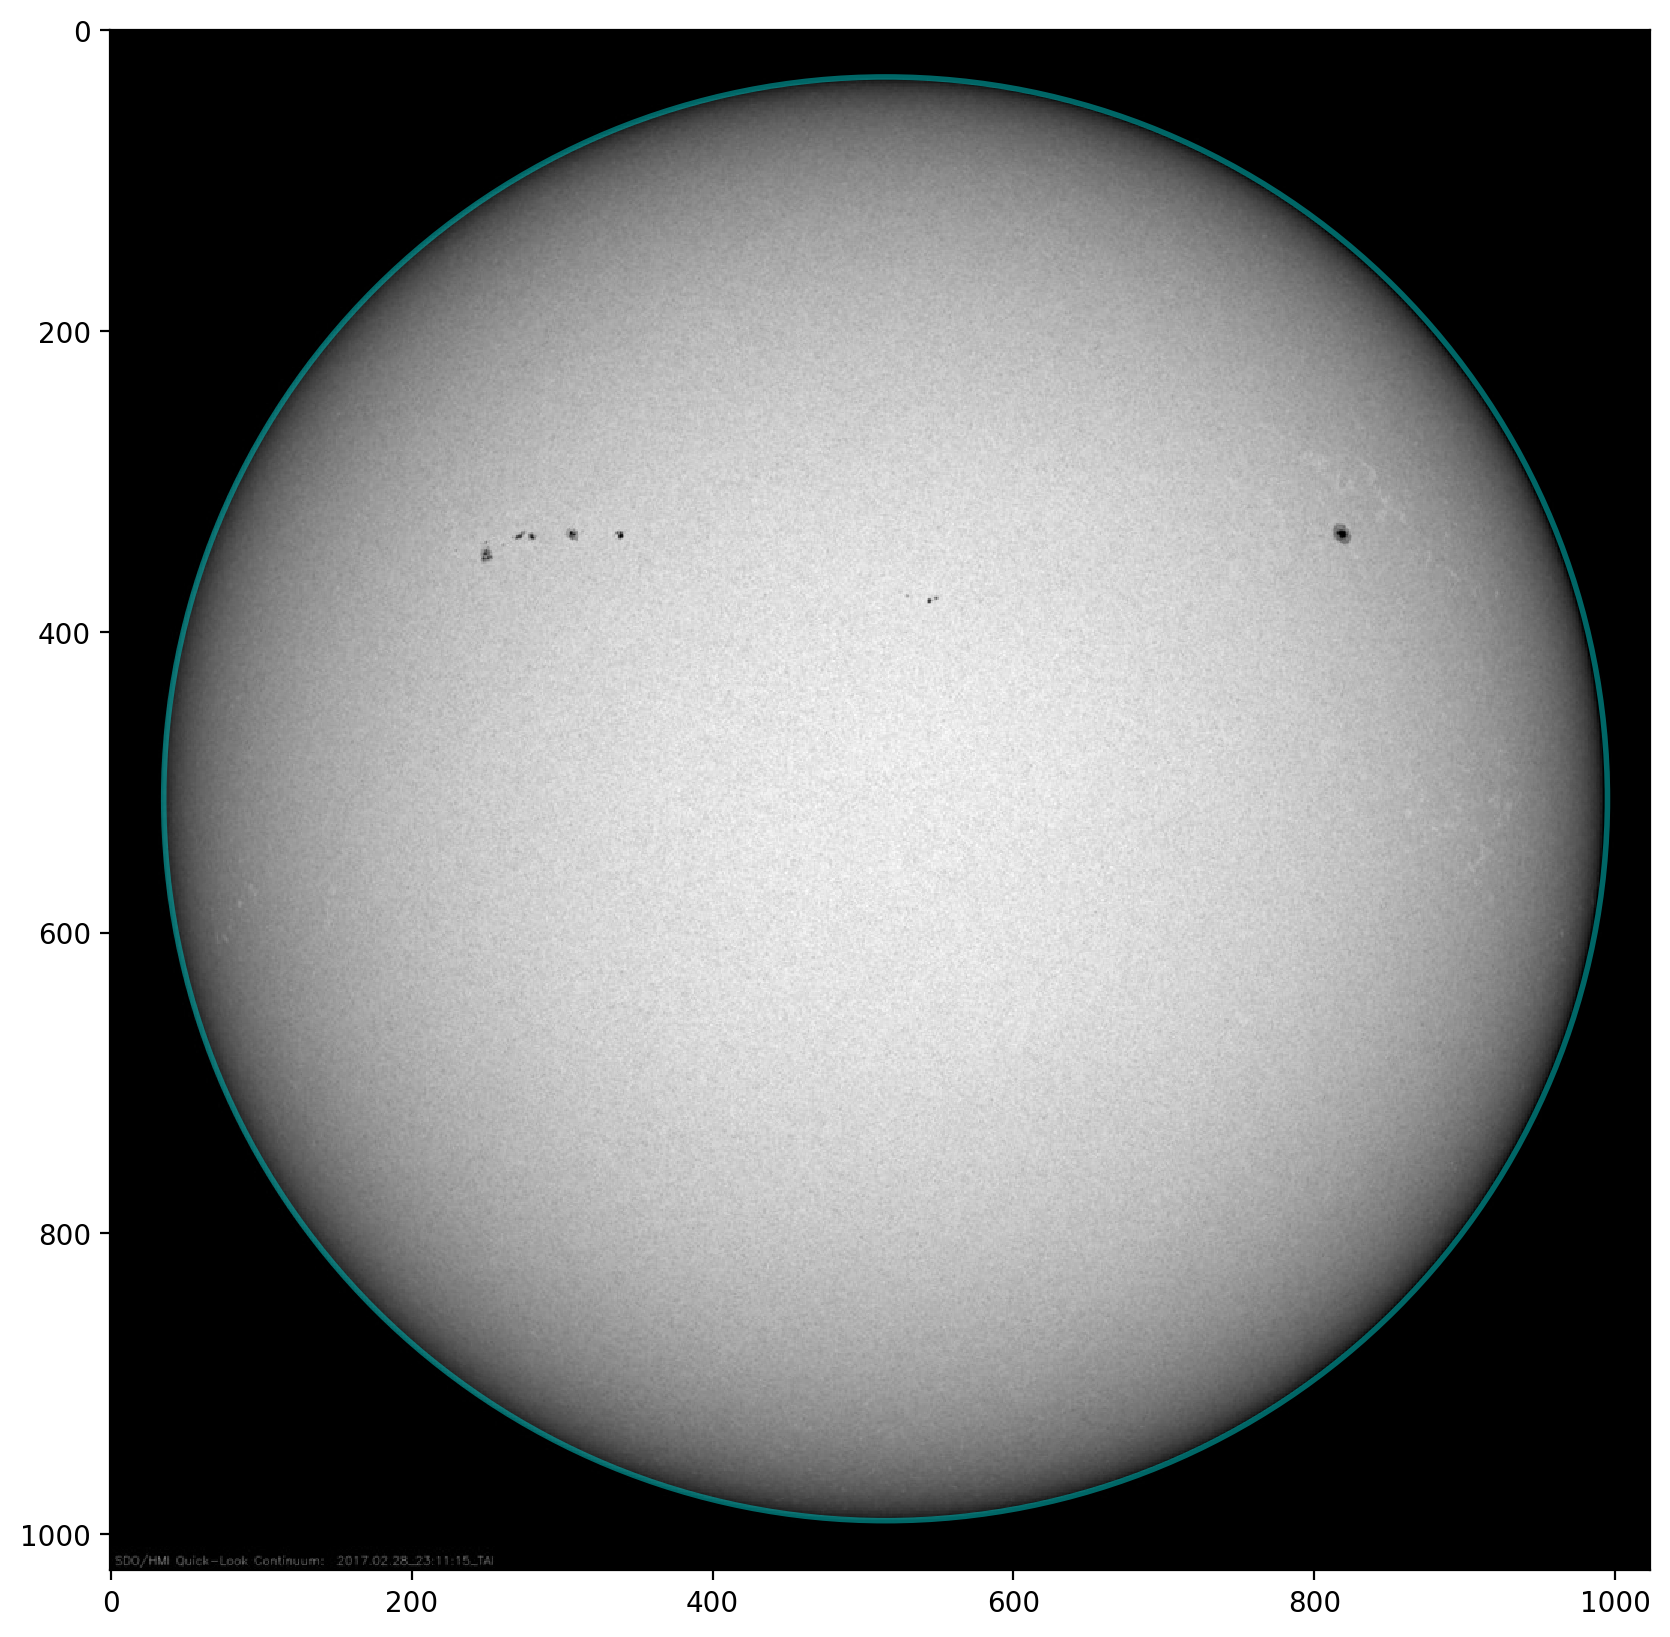

In [ ]:
from matplotlib.patches import Circle

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(sun_im,
           cmap = 'gray',
           #origin='upper',
           interpolation = 'None')

# Drawing circle on the sun image
circle = Circle((sun_circle[0], sun_circle[1]), sun_circle[2],
                facecolor='none',
                edgecolor=(0, 0.8, 0.8), linewidth=2, alpha=0.5)

ax.add_patch(circle)

plt.show()

## 흑점(어두운 픽셀) 찾아내기

태양 이미지에서 흑점은 어떻게 찾을 수 있을까? 일단 픽셀값을 읽어 어두운 픽셀일 경우에 흑점일 가능성이 높을 것입니다. 그렇다면 어두운 픽셀을 찾아내는 간단한 알고리즘으로 흑점을 찾아봅시다.

태양의 사진을 보면 흑점도 검은색이고, 배경도 매우 어두운 색 입니다. 배경 부분을 처리 하기 위해 먼저 태양사진 원본으로 부터 sun_im_output 이라는 변수로 복사하겠습니다.

In [ ]:
# copy image for processing
sun_im_output = sun_im.copy()
print("sun_im_output: ", sun_im_output)

sun_im_output:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [3 0 3 ... 0 0 0]]


### 배경 masking array

검은색 배경은 흑점 판단에 방해가 되므로 배경이 되는 부분을 삭제하기위한 masking array를 생성하고자 합니다. 주연 감광으로 인해 어두워진 가장자리 일부는 흑점 판단에 어려움을 초래하므로 그 경계부분을 잘 결정해야 하는데 여기에서 boundary_width는 위에서 구한 원의 방정식에서 주연 감광으로 어두워진 픽셀들을 제외하기 위한 변수힙니다.

* outer_masking : 주연 감광으로 어두워진 태양 이미지의 가장 자리 영역으로 흑점 판단에 방해가 될 것으로 생각되어 흑점 판단에서 제외할 부분의 bool array

* inner_masking : 가장자리 영역을 제외하고, 흑점이 있는지 판단할 중심 부분의 bool array

In [ ]:
# make masking array for background
X, Y = np.ogrid[0:im_width, 0:im_height]

# 경계 두께 설정
boundary_width = 40 # variable for removing limb darkening area

# 마스킹 bool array  설정
outer_masking = (X - sun_circle[0]) ** 2 + (Y - sun_circle[1]) ** 2 > (sun_circle[2] - boundary_width) ** 2
inner_masking = (X - sun_circle[0]) ** 2 + (Y - sun_circle[1]) ** 2 < (sun_circle[2] - boundary_width) ** 2

print ("type(outer_masking): ", type(outer_masking))
print ("type(inner_masking):", type(inner_masking))
print (np.shape(outer_masking), np.shape(inner_masking))
print ("outer:", outer_masking)
print ("inner", inner_masking)

type(outer_masking):  <class 'numpy.ndarray'>
type(inner_masking): <class 'numpy.ndarray'>
(1024, 1024) (1024, 1024)
outer: [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
inner [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


### 배경 영역 흰색으로 바꾸기

원에서 흑점을 판단할 부분만 남기고 배경 영역은 흰색으로 바꾸었습니다. 이렇게 하면 아쉽지만 boundary width에 해당하는 태양의 가장자리 부분의 흑점은 찾을 수 없게 됩니다.

boundary width : 40


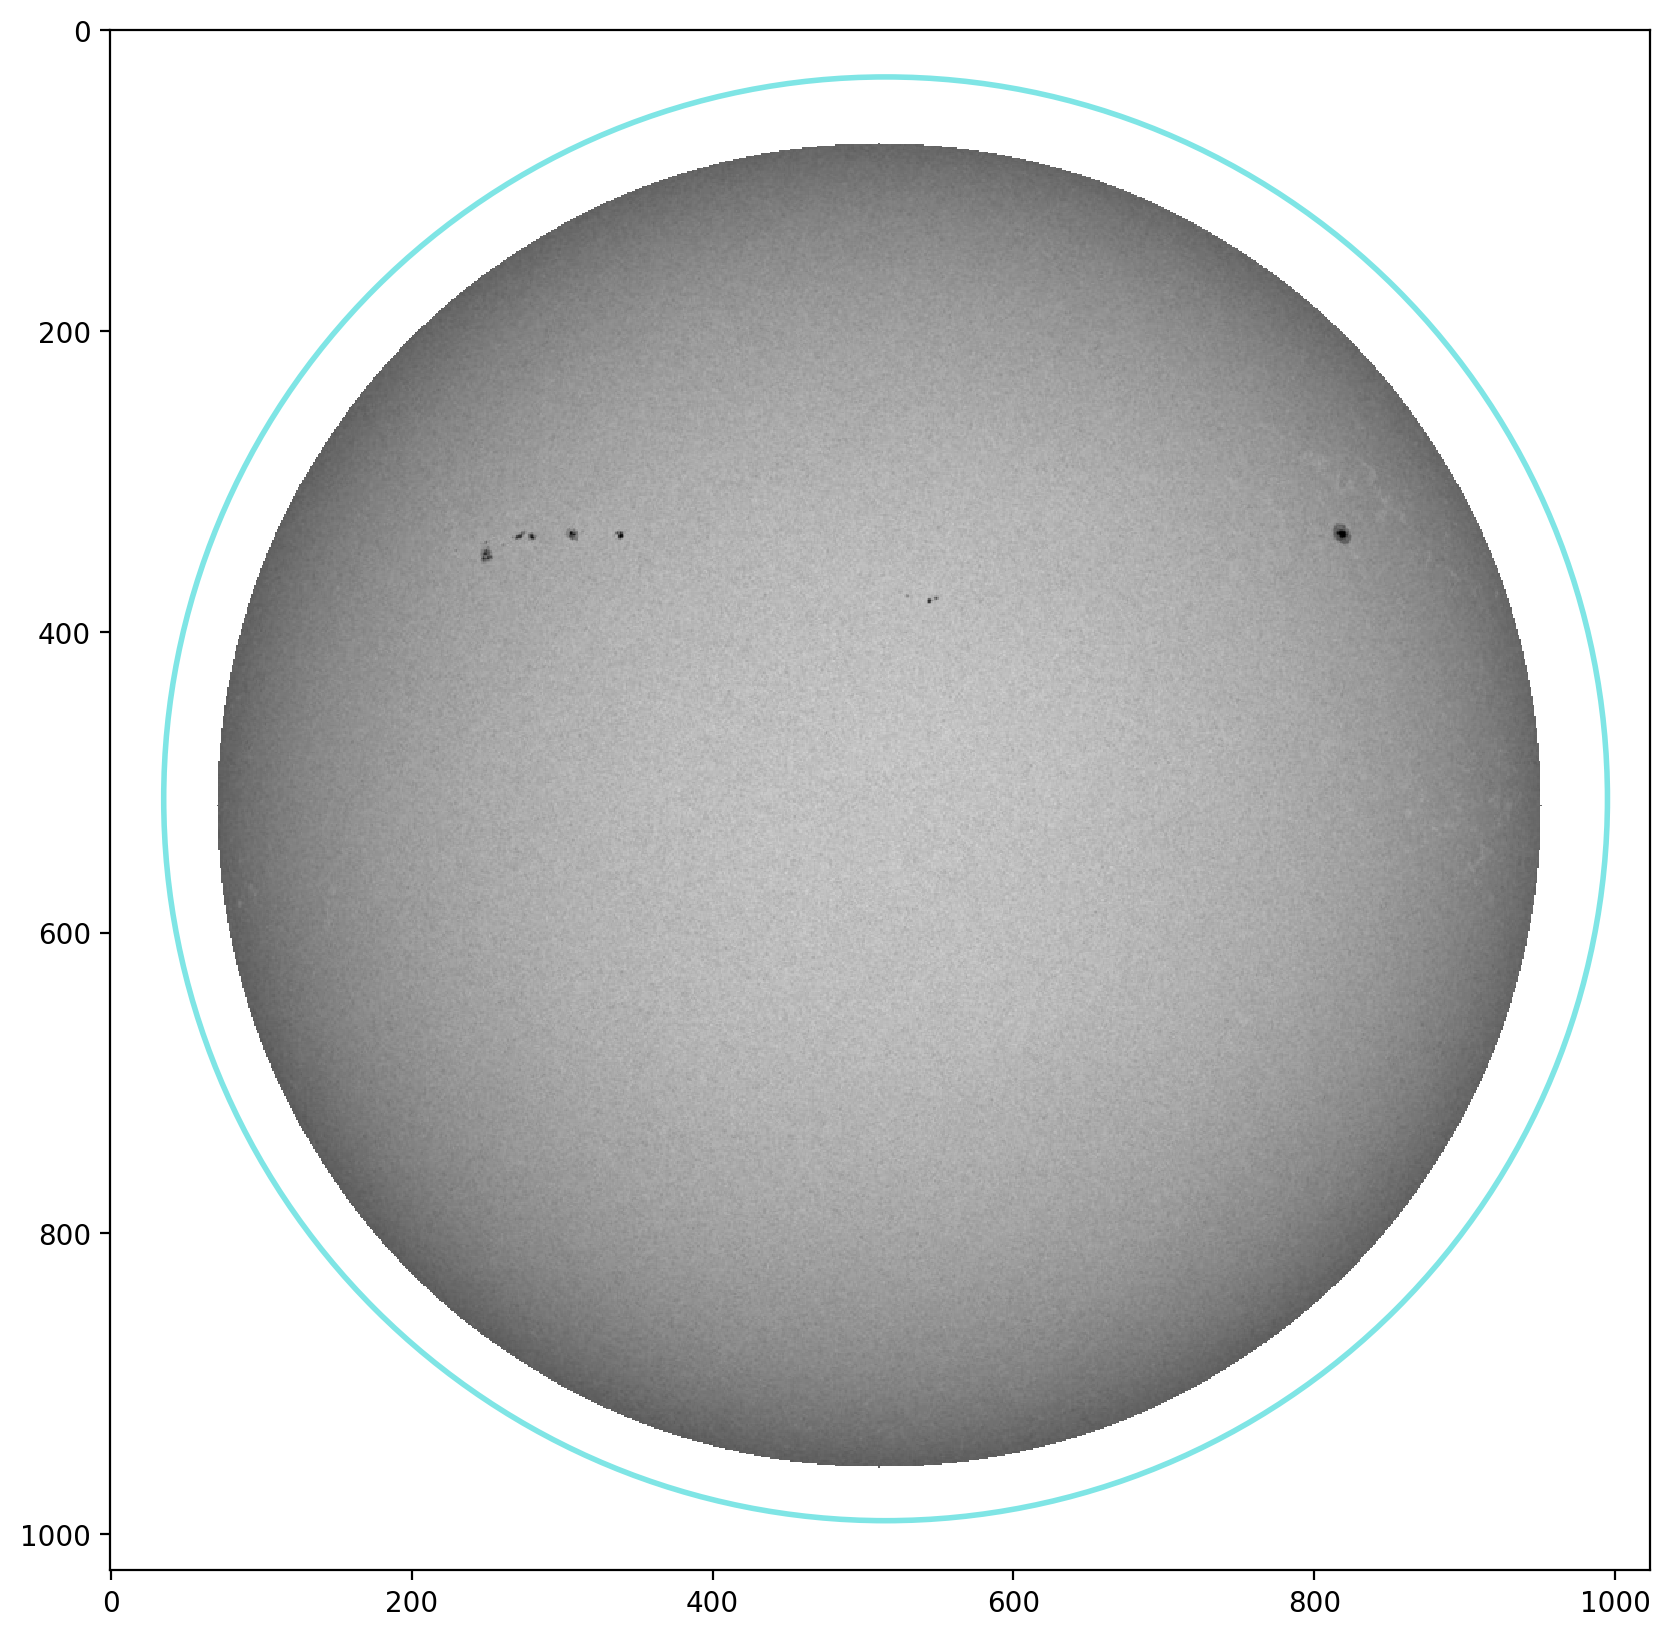

In [ ]:
print ('boundary width :', boundary_width)

# 8 bit image에서 흰색은 255이다.
sun_im_output[outer_masking] = 255
fig, ax = plt.subplots()

# 이미지 나타내기
plt.imshow(sun_im_output,
           cmap = 'gray',
           #origin='upper',
           interpolation = 'None')

# 원 그리기
circle = Circle((sun_circle[0], sun_circle[1]), sun_circle[2],
                facecolor='none',
                edgecolor=(0, 0.8, 0.8), linewidth=2, alpha=0.5)
ax.add_patch(circle)

plt.show()

### 흑점(어두운 픽셀)의 경계값 설정

단순하게 어두운 픽셀을 흑점이라고 판단하기 위하여 bright_criterion 변수를 사용하여 그보다 어두운 부분을 흑점인 픽셀로 판단하는 코드입니다.

먼저 태양 사진과 같은 크기로 흑점을 masking 하기 위한  array 를 만들어 보겠습니다.

In [ ]:
# variable for sunspot criterion
bright_criterion = 70
sunspot_mask  = np.zeros((im_width, im_height)).astype(bool)

sunspot_mask[sun_im_output<bright_criterion] = 1
sunspot_mask[sun_im_output>=bright_criterion] = 0

print(sunspot_mask.shape)
print(sunspot_mask)

(1024, 1024)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


### 흑점(어두운 픽셀) plotting

흑점으로 예상되는 픽셀들만 표출해 보자.

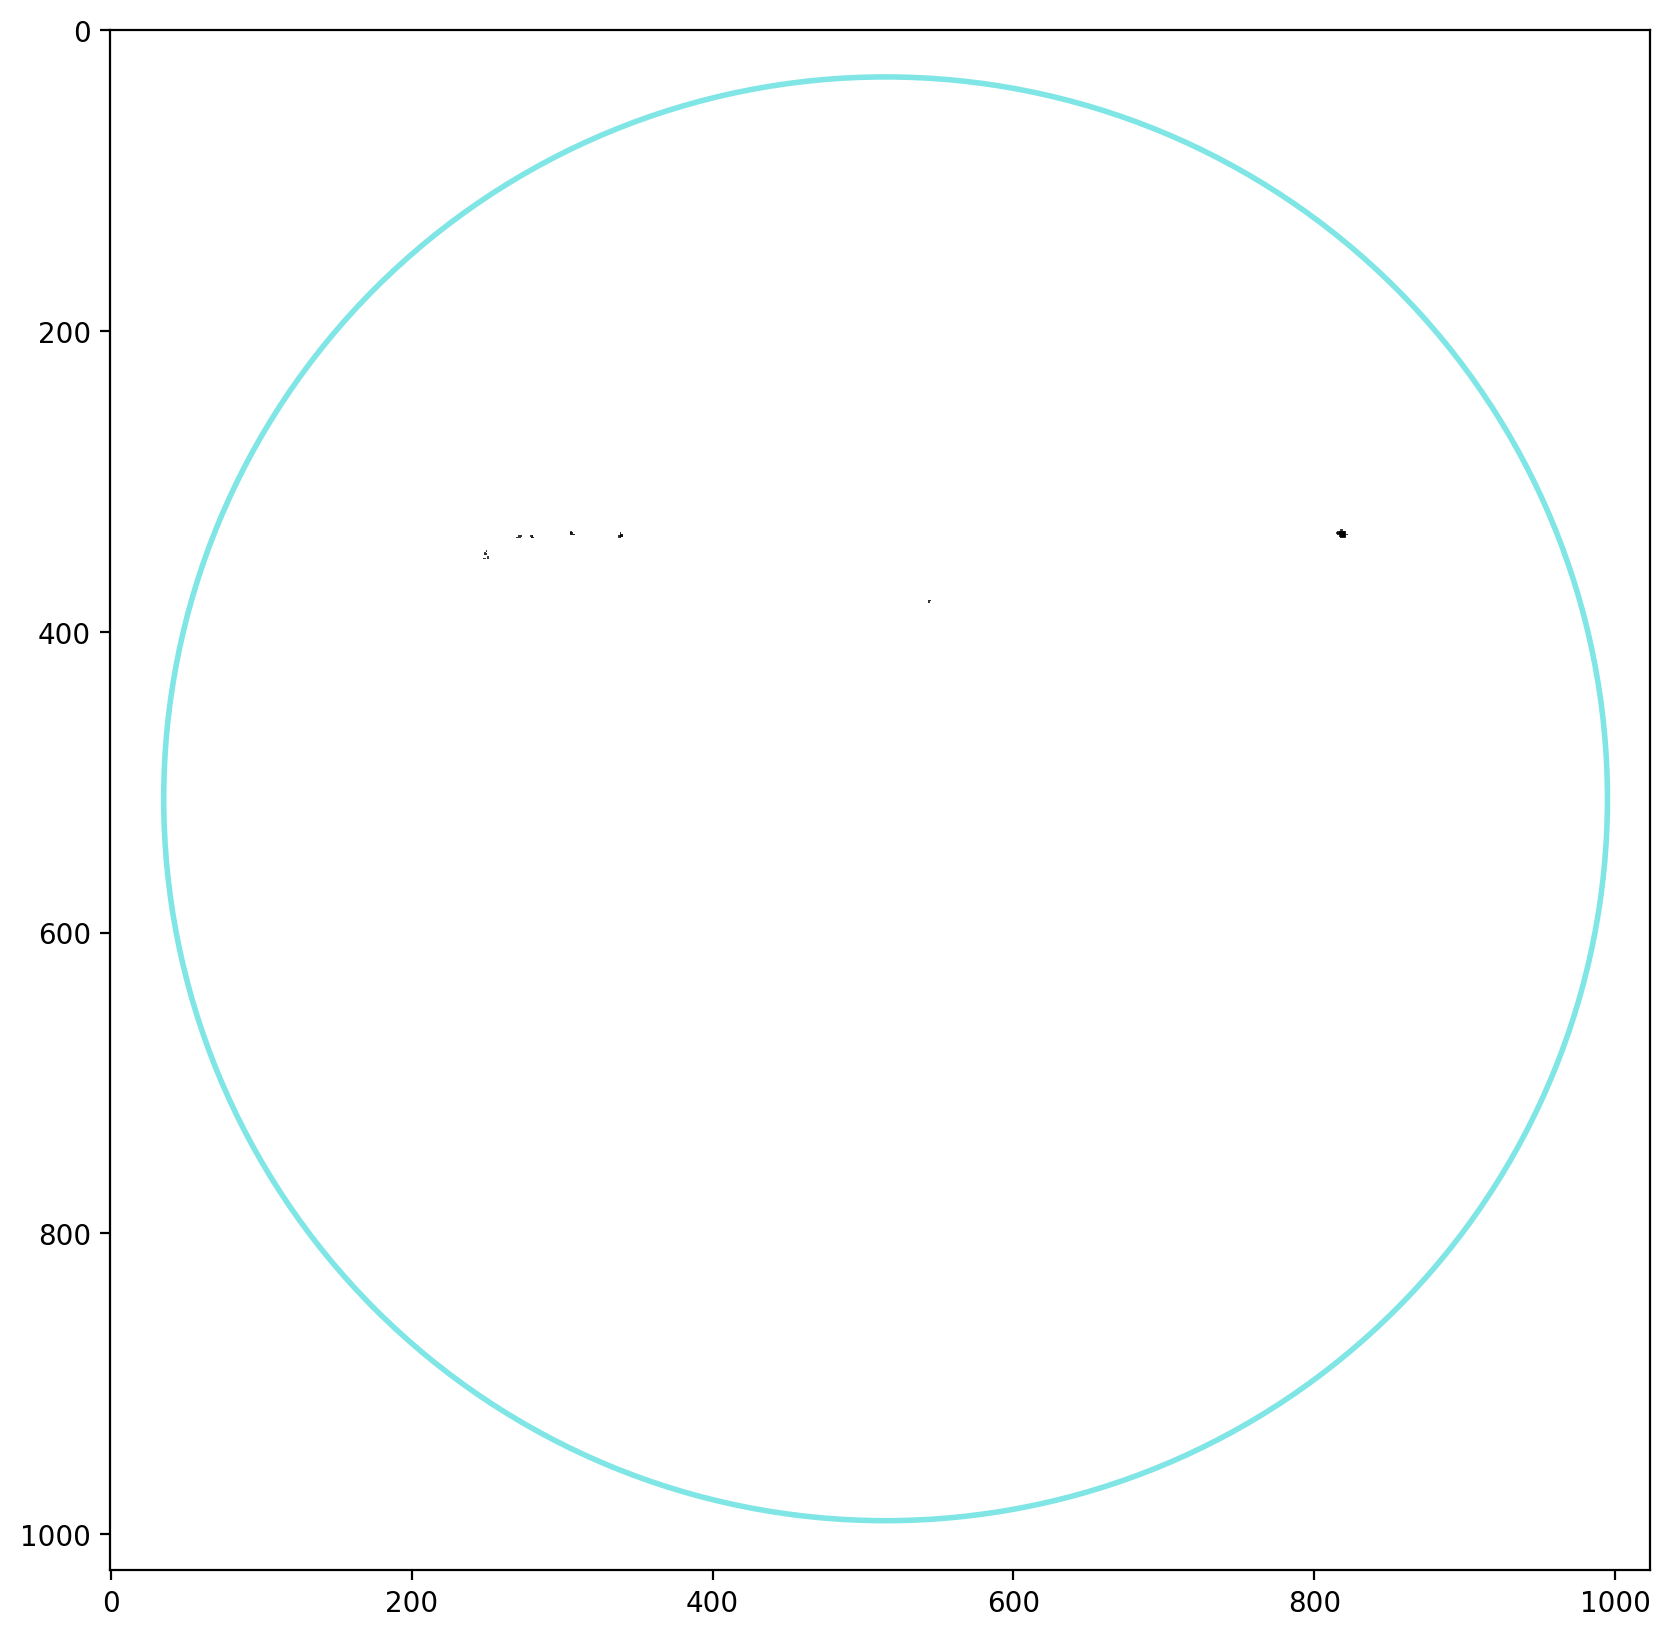

In [ ]:
#non-sunspot pixels will be white
sun_im_output[np.invert(sunspot_mask)] = 255
#print("sun_im_output: ", sun_im_output)

fig, ax = plt.subplots()

# 이미지 나타내기
plt.imshow(sun_im_output,
           cmap = 'gray',
           #origin='upper',
           interpolation = 'None')

#원 그리기
circle = Circle((sun_circle[0], sun_circle[1]), sun_circle[2],
                facecolor='none',
                edgecolor=(0, 0.8, 0.8), linewidth=2, alpha=0.5)
ax.add_patch(circle)

# to hide tick values on X and Y axis
# plt.xticks([]), plt.yticks([])
plt.show()

## 흑점 갯수 구하기

### 흑점(어두운 픽셀) 모으기

흑점(어두운 픽셀) 모으기
흑점이라고 생각되는 픽셀의 좌표와 픽셀값을 check_pixel 변수에 list 형태로 저장한 후 2차원 배열로 만들어 봅니다.

In [ ]:
check_pixel = [] # x, y, intensity
for i in range(0, im_width):
    for j in range(0, im_height):
        if(sun_im_output[i,j] < bright_criterion):
            sunspot_mask[i,j] = 0
            check_pixel.append([j, i, sun_im_output[i,j]])
        else :
            sunspot_mask[i,j] = 1

print("len(check_pixel): ", len(check_pixel))
print("check_pixel: ", check_pixel)

check_pixel = np.asarray(check_pixel)
print("type(check_pixel):", type(check_pixel))
print("check_pixel.shape:", check_pixel.shape)

len(check_pixel):  66
check_pixel:  [[818, 332, 63], [819, 332, 66], [306, 333, 64], [816, 333, 50], [817, 333, 21], [818, 333, 10], [819, 333, 10], [820, 333, 16], [821, 333, 56], [306, 334, 13], [307, 334, 50], [339, 334, 51], [815, 334, 65], [816, 334, 18], [817, 334, 0], [818, 334, 0], [819, 334, 1], [820, 334, 0], [821, 334, 28], [306, 335, 37], [307, 335, 45], [308, 335, 30], [339, 335, 25], [340, 335, 29], [816, 335, 45], [817, 335, 14], [818, 335, 0], [819, 335, 1], [820, 335, 0], [821, 335, 14], [822, 335, 59], [271, 336, 55], [272, 336, 51], [273, 336, 62], [279, 336, 65], [280, 336, 35], [338, 336, 49], [339, 336, 2], [340, 336, 17], [817, 336, 49], [818, 336, 6], [819, 336, 1], [820, 336, 0], [821, 336, 27], [270, 337, 51], [271, 337, 55], [272, 337, 61], [280, 337, 17], [281, 337, 41], [338, 337, 65], [339, 337, 33], [818, 337, 35], [819, 337, 20], [820, 337, 44], [821, 337, 68], [250, 346, 64], [249, 347, 69], [249, 348, 44], [250, 348, 51], [251, 350, 66], [248, 351, 34]

### 픽셀 plotting

 흑점의 픽셀 좌표를 화면에 polt 파란색으로 plotting해 보겠습니다.

number of pixels for for checking if it is sunspot or not : 66


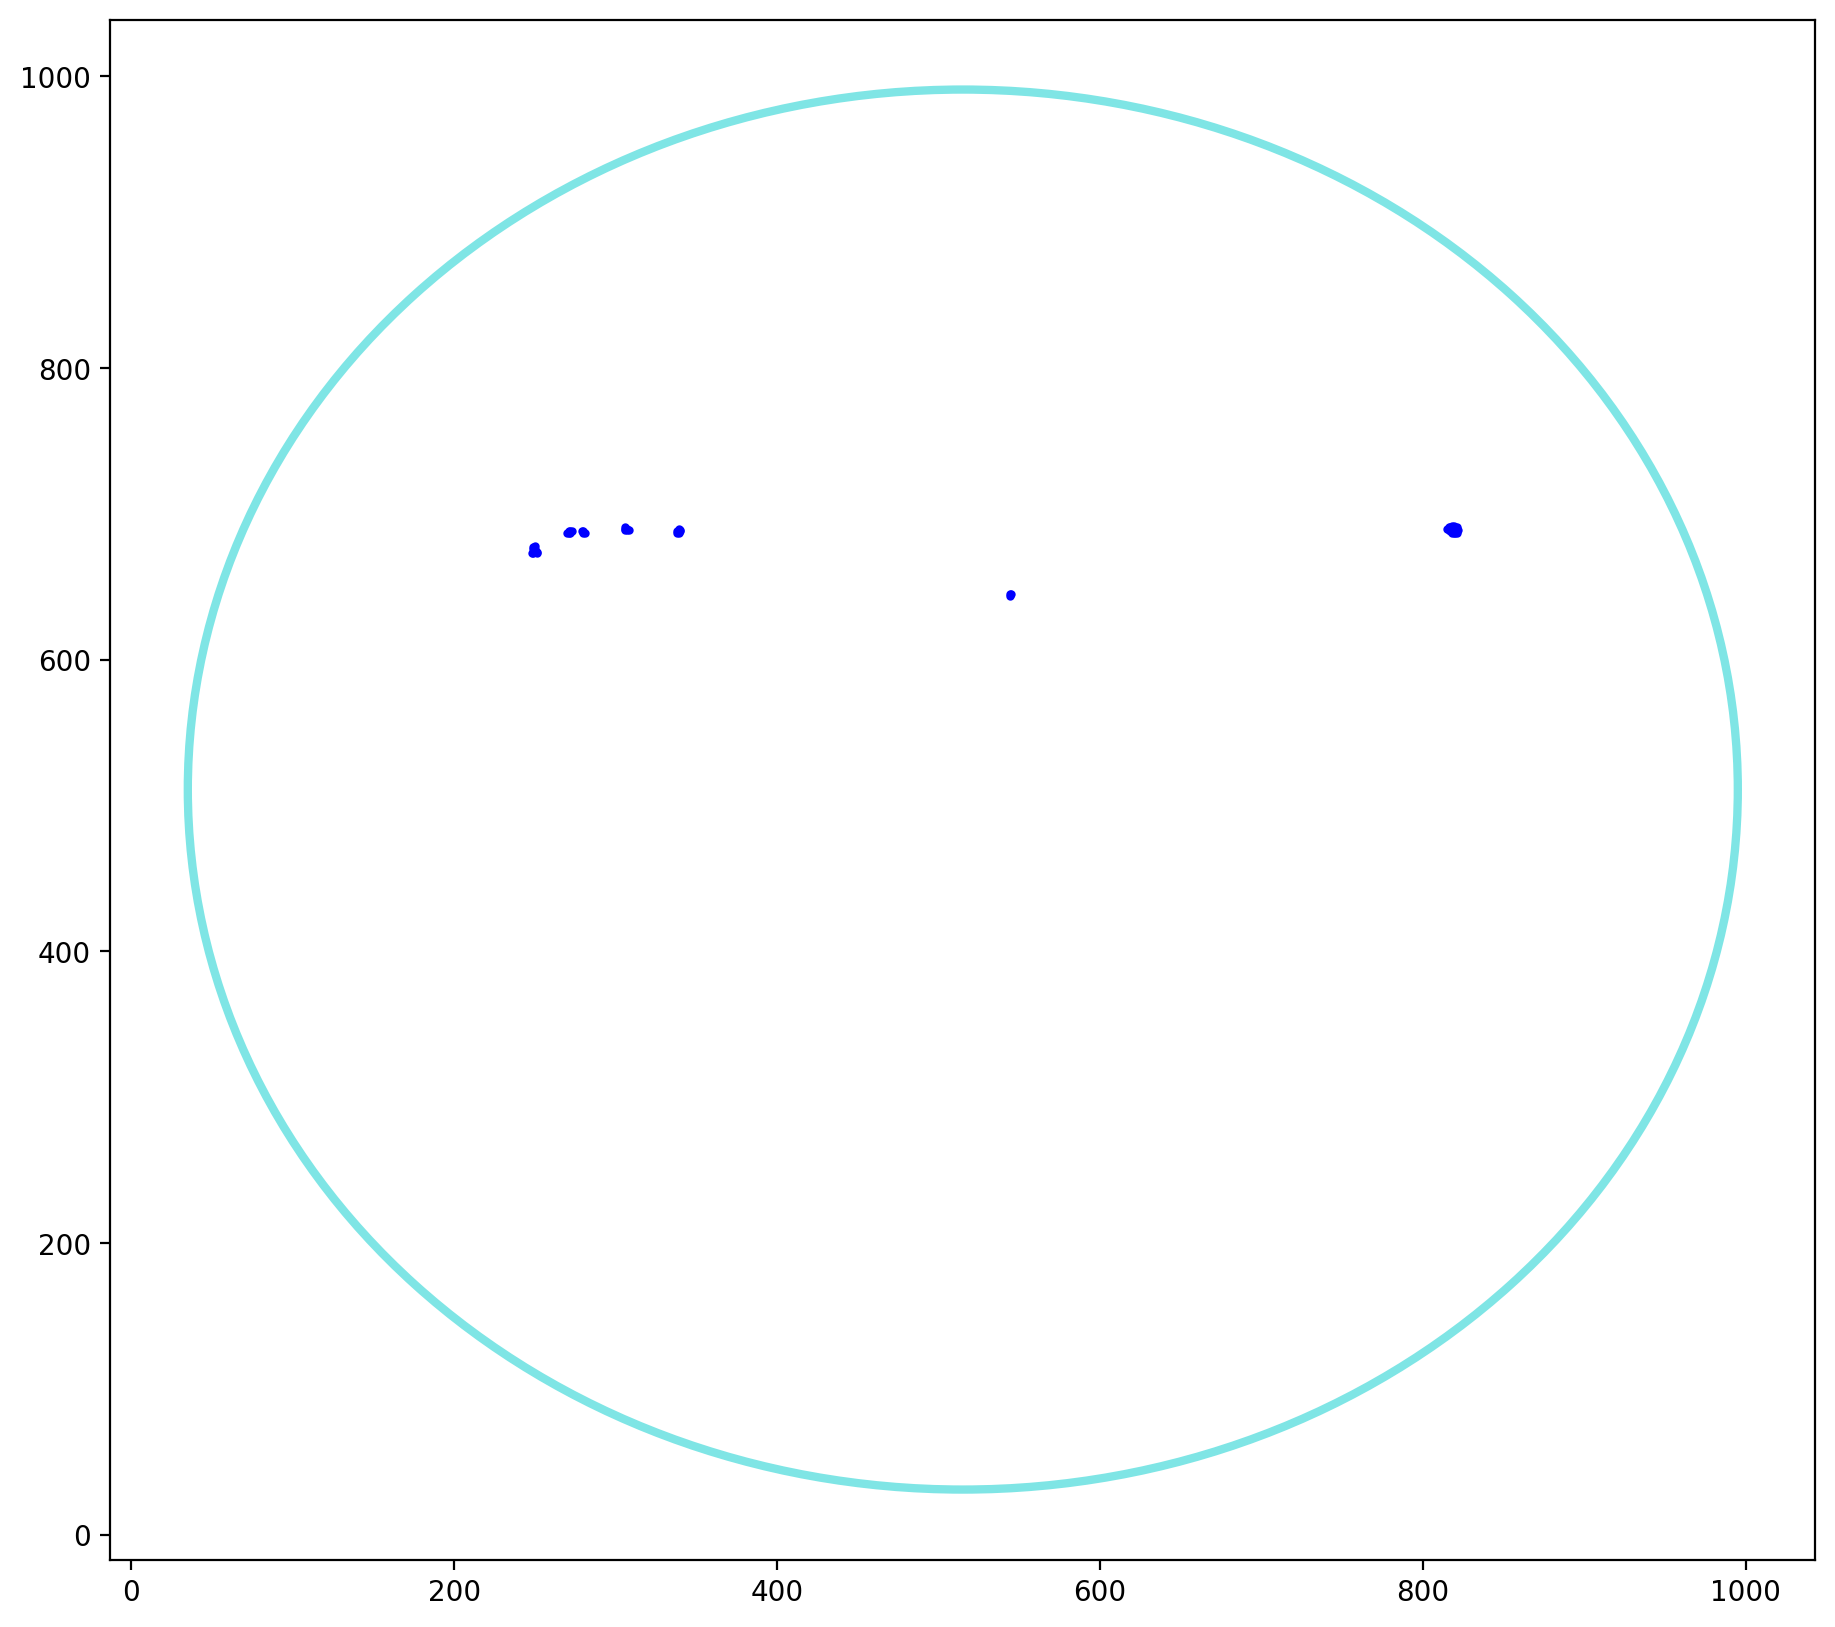

In [ ]:
print ('number of pixels for for checking if it is sunspot or not :', len(check_pixel))

#print (check_pixel)
if len(check_pixel) == 0 :
    print('There is no sunspot pixel in the image')
else :
    fig,ax = plt.subplots()

    l = plt.plot(check_pixel[:,0],
                 (im_height-check_pixel[:,1]),
                 'bo',
                 markersize=2)

    # 원 그리기
    circle = Circle((sun_circle[0], sun_circle[1]), sun_circle[2],
                    facecolor='none',
                    edgecolor=(0, 0.8, 0.8), linewidth=3, alpha=0.5)
    ax.add_patch(circle)

    # to hide tick values on X and Y axis
    #plt.xticks([]), plt.yticks([])

    plt.show()


### 흑점 픽셀 데이터 만들기

흑점만 골라서 plotting 하기 위하여 sunspot_mask에 해당하는 좌표는 1, 나머지는 0인 image라는 이름의 ndarray를 만들어 plotting 해 보겠습니다.

sunspot_mask:  [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
image : [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


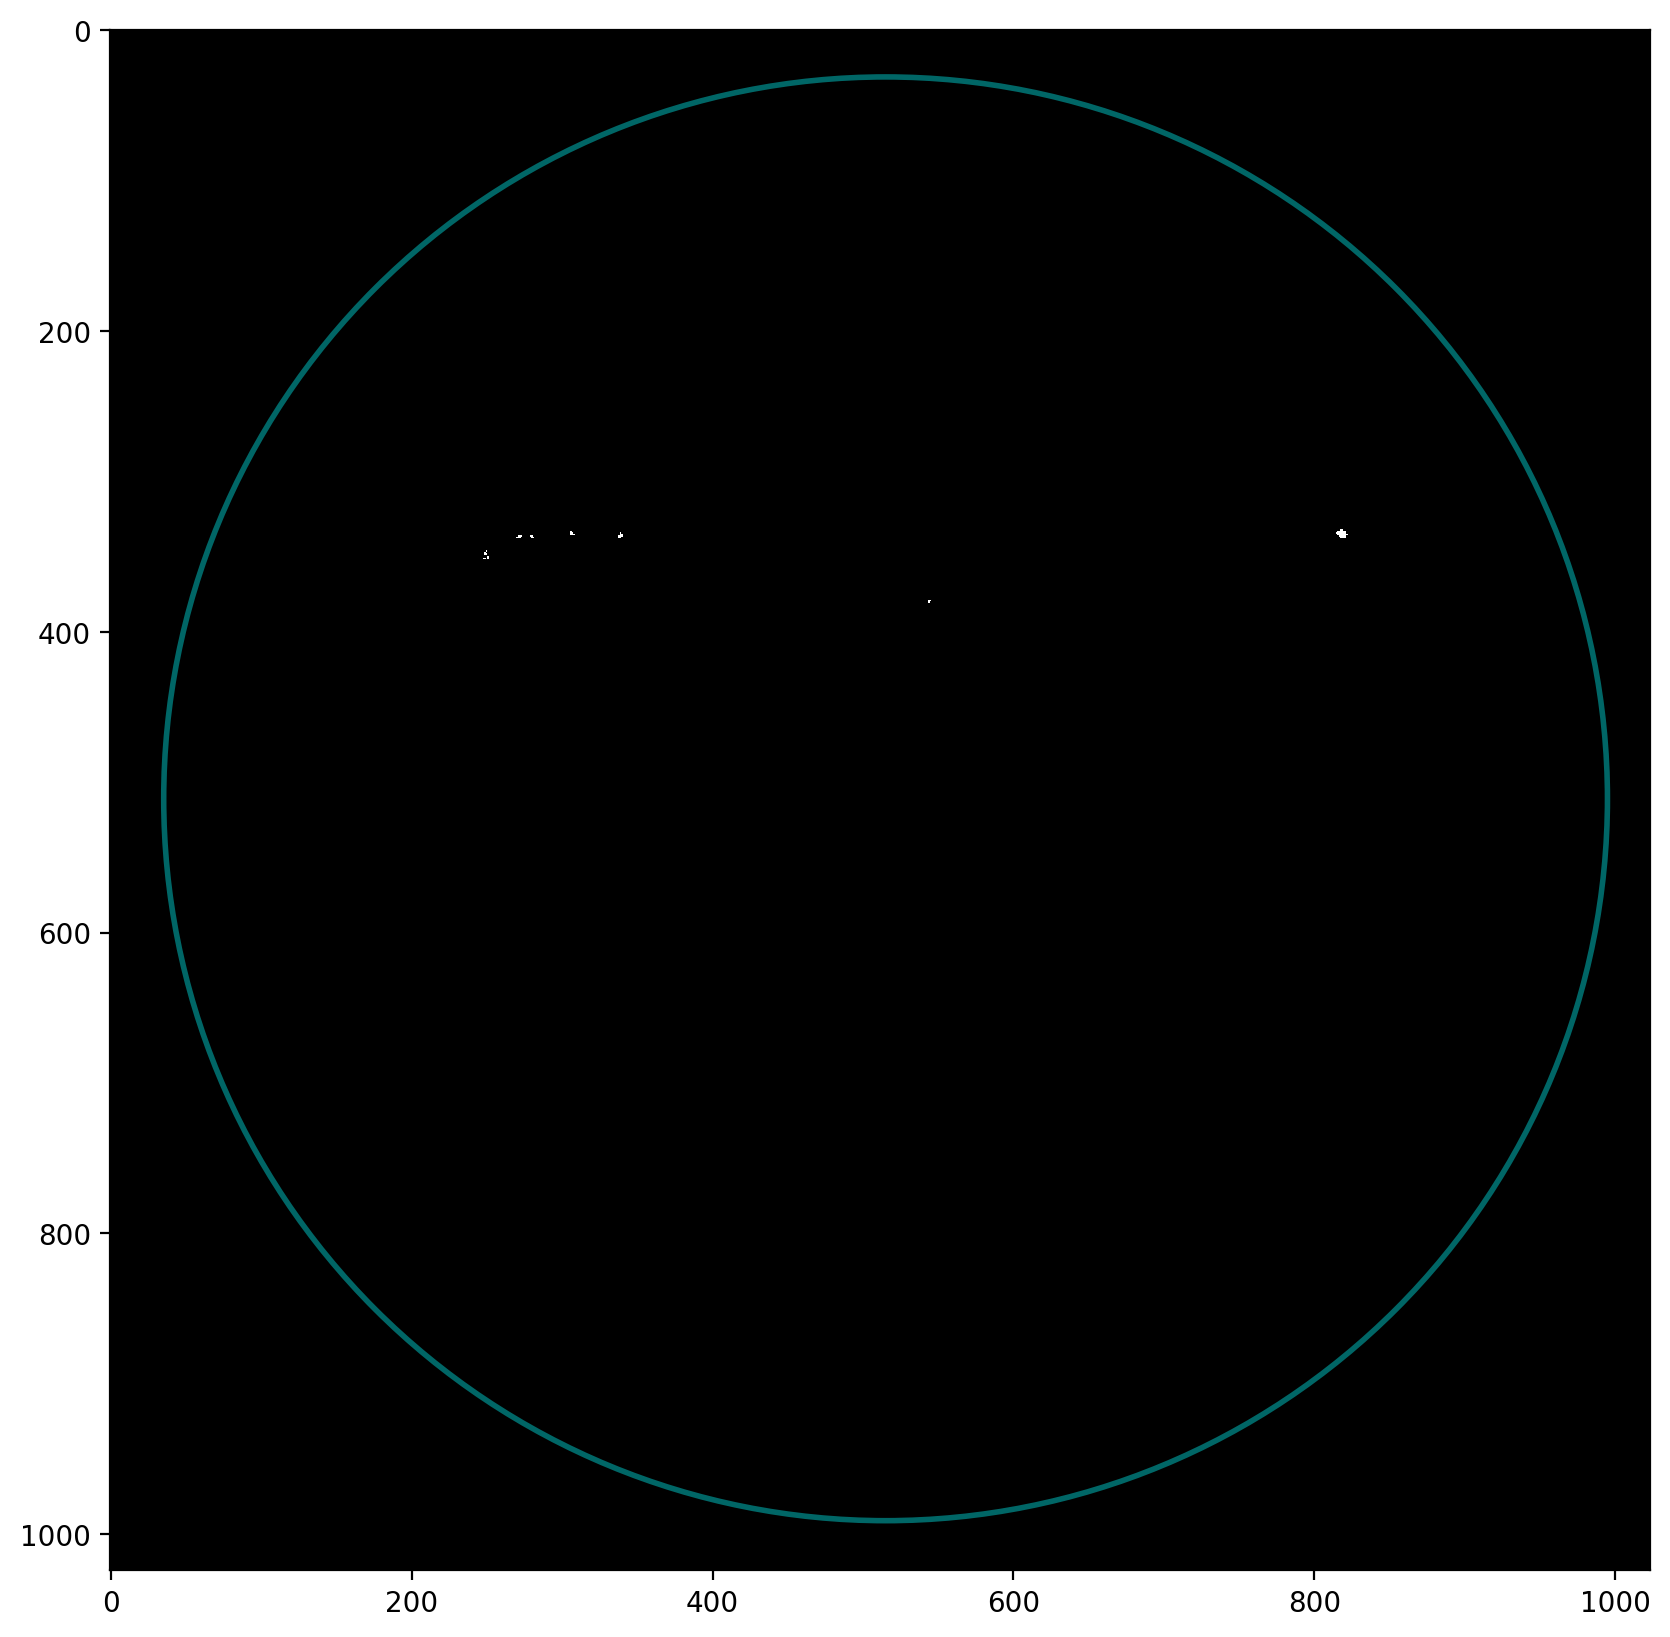

In [ ]:
print("sunspot_mask: ", sunspot_mask)
image = np.invert(sunspot_mask).astype(int)
print("image :", image)

fig, ax = plt.subplots()

# 이미지 나타내기
plt.imshow(image,
           cmap = 'gray',
           interpolation = 'None')

#원 그리기
circle = Circle((sun_circle[0], sun_circle[1]), sun_circle[2],
                facecolor='none',
                edgecolor=(0, 0.8, 0.8), linewidth=2, alpha=0.5)
ax.add_patch(circle)

# to hide tick values on X and Y axis
#plt.xticks([]), plt.yticks([])

plt.show()

### 흑점 좌표의 위도, 경도 구하기

흑점의 x, y 좌표로 부터 위도와 경도를 구하는 사용자 정의 함수를 만들어 보겠습니다. 이 과정에서 앞에서 알아낸 원의 방정식을 이용하였습니다.


In [ ]:
# Calculation of latitude and longitude of sunspot on sun
import math
def latitude(y):
    return math.asin( (sun_circle[1] - y) / sun_circle[2] )

def longitude(x, y):
    return math.asin( (x - sun_circle[0]) / (sun_circle[2] * math.cos(latitude(y))) )

### DFS algorithm

[DFS algorithm](https://en.wikipedia.org/wiki/Depth-first_search)는 깊이 우선 탐색 알고리즘이고,  check_pixel 변수에 저장되어 있는 pixel들로 흑점을 판단하기 위해 다음과 같이 DFS algorithm을 사용자 정의 함수로 만들수 있습니다.

In [ ]:
#######################################################
#### DFS range. Need to determine this taxi radius.####
dx = [0, 1, 1, 1, 0, -1, -1, -1]
dy = [1, 1, 0, -1, -1, -1, 0, 1]
#######################################################
def dfs(x, y): # DFS(Depth First Search)
    global x_pixel_sum
    global y_pixel_sum
    global num_pixel
    image[x][y] = -1 # mark as already visited.
    x_pixel_sum += x
    y_pixel_sum += y

    num_pixel += 1
    for i in range(0, len(dx)):
        if(image[x+dx[i]][y+dy[i]] == 1):
            dfs(x+dx[i], y+dy[i])
#######################################################

check_pixel 변수에 저장되어 있는 pixel들이 2개 이상 인접해 있는 경우만 흑점으로 판단하기 위하여 DFS 알고리즘을 적용하겠습니다.

In [ ]:
# identify sunspot from check_pixel
pixel_num_criterion = 2

#x_average, y_average, num_pixel
sunspot_data = []

for a in range(0, im_width):
    for b in range(0, im_height):
        if(image[a][b] == 1):
            x_pixel_sum = 0
            y_pixel_sum = 0
            num_pixel = 0
            print('DFS...', a, b)
            dfs(a, b)
            if num_pixel > pixel_num_criterion :
                x_average = x_pixel_sum / num_pixel
                y_average = y_pixel_sum / num_pixel
                latit = latitude(y_average)
                longi = longitude(x_average, y_average)
                latit = math.degrees(latit)
                longi = math.degrees(longi)
                #sunspot_data.append([longi, latit, num_pixel])
                sunspot_data.append([int(x_average), int(y_average), longi, latit, num_pixel])
print ('*'*80)
print ('number of sunspot : ', len(sunspot_data))
print ('sunspot data : ', sunspot_data) #x, y, num_pixel

DFS... 332 818
DFS... 333 306
DFS... 334 339
DFS... 336 271
DFS... 336 279
DFS... 346 250
DFS... 350 251
DFS... 351 248
DFS... 379 544
********************************************************************************
number of sunspot :  7
sunspot data :  [[334, 818, -29.318037369175673, -39.871042978914225, 31], [334, 306, -24.579816234710872, 25.19462739906065, 6], [335, 339, -23.578179451026763, 20.99787554593272, 8], [336, 271, -25.410881515476927, 29.931107784083128, 6], [336, 280, -25.1020811038634, 28.767073349324946, 4], [347, 249, -24.629910801625122, 33.010428011528255, 4], [379, 544, -16.458625176932003, -3.9820785775816097, 3]]


### 태양 이미지 위에 흑점 표현하기

흑점의 좌표를 표시하기 위하여  먼저 흑점의 좌표를 array로 변환하자.

In [ ]:
sunspot_data = np.asarray(sunspot_data)
print("sunspot_data:\n", sunspot_data)

sunspot_data:
 [[334.         818.         -29.31803737 -39.87104298  31.        ]
 [334.         306.         -24.57981623  25.1946274    6.        ]
 [335.         339.         -23.57817945  20.99787555   8.        ]
 [336.         271.         -25.41088152  29.93110778   6.        ]
 [336.         280.         -25.1020811   28.76707335   4.        ]
 [347.         249.         -24.6299108   33.01042801   4.        ]
 [379.         544.         -16.45862518  -3.98207858   3.        ]]


다음과 같이 태양 사진 위에 흑점의 좌표를 표시하여 저장합니다.

Number of sunspot: 7
SDO_images/20170228_231038_1024_HMII.png is created...


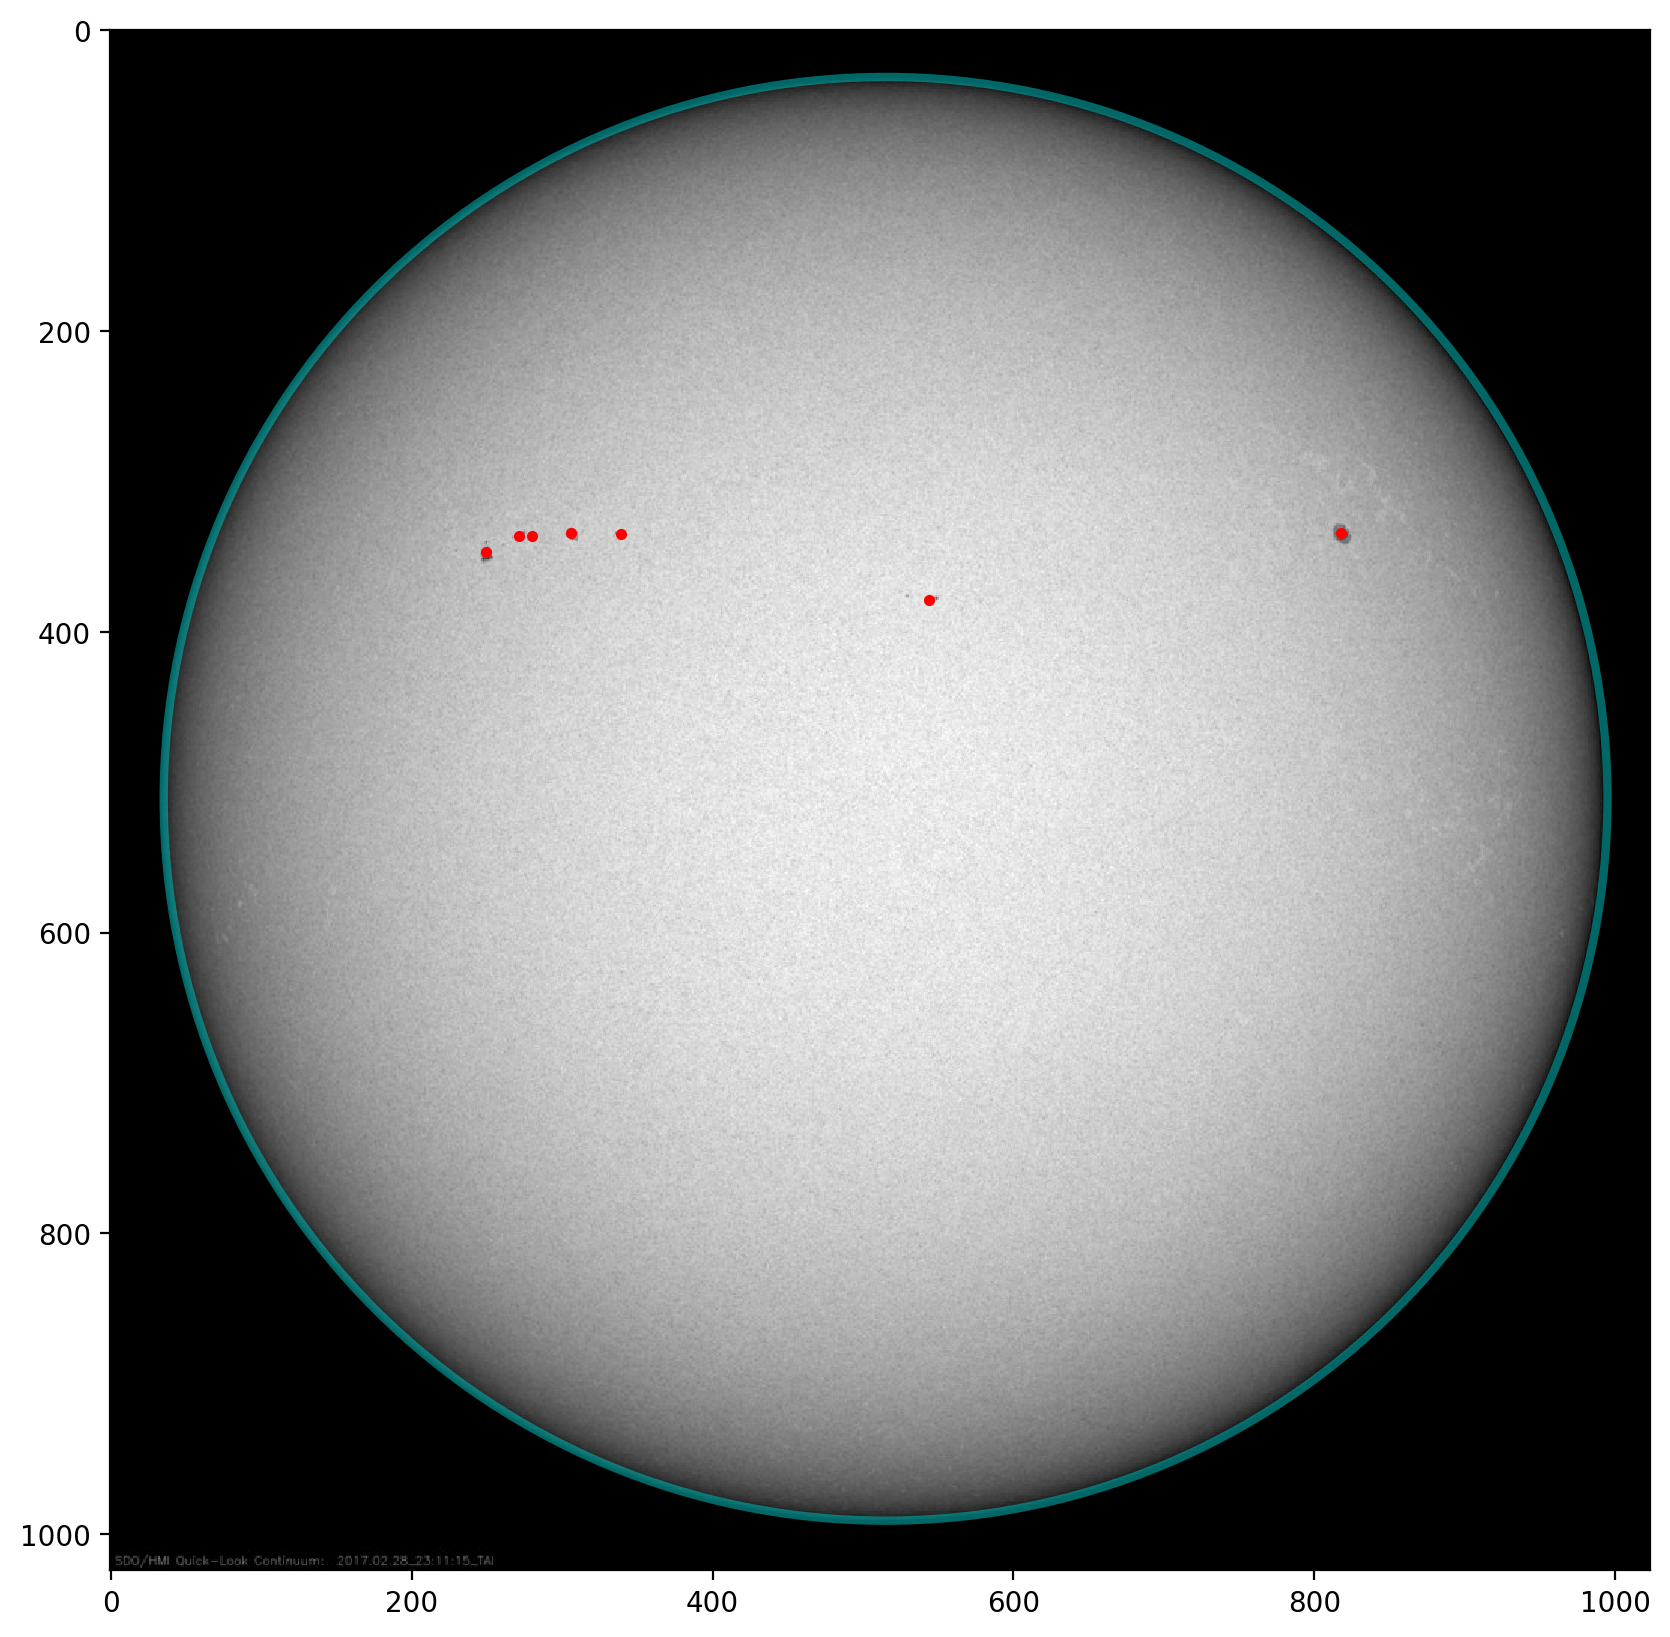

In [ ]:
if len(sunspot_data) == 0 :
    print('There is no sunspot in the image')
else :
    print(f'Number of sunspot: {len(sunspot_data)}')
    fig,ax = plt.subplots()
    # load the sun image
    plt.imshow(sun_im,
               cmap = 'gray',
               interpolation = 'None')

    # draw a circle
    circle = Circle((sun_circle[0], sun_circle[1]), sun_circle[2],
                    facecolor='none',
                    edgecolor=(0, 0.8, 0.8), linewidth=3, alpha=0.5)
    ax.add_patch(circle)

    # plot sunspot
    plt.plot(sunspot_data[:,1],
             (sunspot_data[:,0]),
             'ro',
             markersize=3)

    # savefig
    plt.savefig(f'{str(fpaths[0].parents[0])}/{fpaths[0].stem}.png')
    print(f'{str(fpaths[0].parents[0])}/{fpaths[0].stem}.png is created...')
    plt.show()

##(과제)

다음에 해당하는 SDO 자료를 받아 위의 프로세스를 수행해 보세요.

* 일시: 2015년 자신의 생일날 정오(KST) 무렵

* SDO 자료 중 1024 pixel의 HMII


In [ ]:
#(과제) 아래 코딩을 완성하여 제출하시오.

!wget https://sdo.gsfc.nasa.gov/assets/img/browse/2015/01/02/20150102_032325_1024_HMII.jpg






--2024-12-09 06:49:29--  https://sdo.gsfc.nasa.gov/assets/img/browse/2015/01/02/20150102_032325_1024_HMII.jpg
Resolving sdo.gsfc.nasa.gov (sdo.gsfc.nasa.gov)... 129.164.137.36, 2001:4d0:2310:1f0::36
Connecting to sdo.gsfc.nasa.gov (sdo.gsfc.nasa.gov)|129.164.137.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163496 (160K) [image/jpeg]
Saving to: ‘20150102_032325_1024_HMII.jpg.2’

20150102_032325_102 100%[===================>] 159.66K   745KB/s    in 0.2s    

2024-12-09 06:49:30 (745 KB/s) - ‘20150102_032325_1024_HMII.jpg.2’ saved [163496/163496]

